# Coursera Capstone Project - The Battle of the Neighborhoods


## -- A Survey of the Mexican Restaurants in New York City --


#### Robert Gray



## Introduction

I've chosen to explore the locations and reviews of Mexican restaurants in New York City.  

New York City (NYC), the largest and most densely populated city in the United States, has a population of over 8.3 million (as of 2019).  NYC is one of the most important cultural, financial, and media centers of the world.  It consists of five boroughs - Manhattan, Brooklyn, Queens, the Bronx, and Staten Island.  It has been the most important point of legal immigration into the United States.  Hundreds of languages are spoken in NYC.
The city holds a huge array of international cuisines and contains over 27,000 restaurants.  

In particular, I love Mexican food and I often travel to NYC and am interested in where to find the areas with the most and best Mexican food.  I also would like to investigate where a good place would be to open a Mexican restaurant.

 
  
  


## Data

For this project, I will use the dataset https://cocl.us/new_york_dataset which contains New York City's location data for each of the boroughs and neighborhoods therein.

I will also use Foursquare's API to explore the venues in each borough and neighborhood, choose the Mexican restaurants, and then to extract details of each including ratings, number of likes, and tips.
 
  
   

## Methodology

First I will use the dataset from https://cocl.us/new_york_dataset to extract the location data (latitude and longitude) for each neighborhood in all five of NYC's boroughs.  I'll look at how many neighborhoods are in each borough to get an idea of the size variations.

Then I'll utitlize Foursqure API calls to gather the names and IDs of all venues within 700 meters of the neighborhood center, along with the borough and neighborhood it resides in, saving just the Mexican restaurants.  I can then determine how many Mexican restaurants are in each of the five boroughs, and how many are in each of the neighborhoods within each borough.  

Then, for each Mexican restaurant I've stored, I can go through and make a Foursquare API to pull the rating, "likes" and tips for each restaurant.  Once I have this, I can average the ratings for each borough, and each of the borough's neighborhoods.  This will show places having the best Mexican food!

Then I'll put the top Mexican restaurants on a folium map.  When the user clicks on the restaurant's marker, a popup will show the borough, neighborhood, and ranking of the restaurant. 

I would like to pick a place I think would be a good place to start a Mexican restaraunt based on the data pulled above.



## Problem Statement

What areas (boroughs and neighborhoods) have the best Mexican restaurants?

Which restaurants can be singled out as being the top Mexican restaurants in NYC?

If I were to open a Mexican restaurant in NYC, where would I do so?

## Data Analysis

### Import Libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as pyplot
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import os

# Folium for maps
!pip install folium
import folium

print("Libaries imported")

Libaries imported


In [4]:
# Set up FourSquare credentials to be used later on
CLIENT_ID = 'CUIA3OF2C2UBOPRIFH2EK5OLFXJNCJKKHFHRMMW0H3NUS35J' # your Foursquare ID
CLIENT_SECRET = '5OYFH4ZK1YLIU4DC43XC0MIBT4D0Z4B3DGQMUAOQYQAZ14NT' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CUIA3OF2C2UBOPRIFH2EK5OLFXJNCJKKHFHRMMW0H3NUS35J
CLIENT_SECRET:5OYFH4ZK1YLIU4DC43XC0MIBT4D0Z4B3DGQMUAOQYQAZ14NT


### Download and extract the New York geographical data for boroughs and neighborhoods.

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [7]:
# Pull out neighborhoods data via 'features'
neighborhoods_data = newyork_data['features']

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
NYCneighborhoods = pd.DataFrame(columns=column_names)

In [9]:
# Fill neighborhoods dataframe with the extracted data
for data in neighborhoods_data:
    # Borough and Neighborhood name in the properties.    
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    #Latitude and longitude in the geometry.        
    neighborhood_ll = data['geometry']['coordinates']
    neighborhood_lon = neighborhood_ll[0]
    neighborhood_lat = neighborhood_ll[1]
    
    # Append each Borough/Neighborhood/Lat/Log into Neighborhoods dataframe.
    NYCneighborhoods = NYCneighborhoods.append({'Borough': borough,
    'Neighborhood': neighborhood_name, 'Latitude': neighborhood_lat,
    'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
NYCneighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
# Check the data size
NYCneighborhoods.shape

(306, 4)

### Check the number of neighborhoods in each borough.

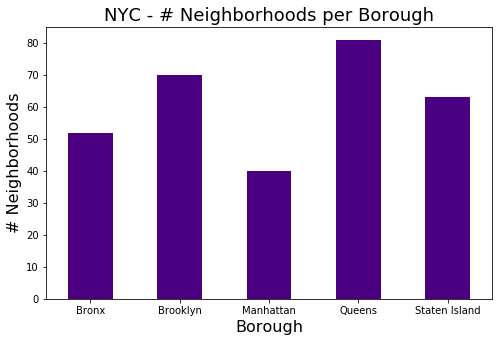

In [12]:
NYCneighborhoods.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(8,5), color="indigo")
pyplot.title('NYC - # Neighborhoods per Borough', fontsize = 18)
pyplot.xlabel('Borough', fontsize = 16)
pyplot.xticks(rotation = 'horizontal')
pyplot.ylabel('# Neighborhoods',fontsize = 16)
pyplot.show()

### Set up a function to get the venues from Foursquare API given a latitude, longitude, radius (meters), and size limit.  A python dataframe is returned.

In [13]:
# Will be using Foursquare to get the venues around each of the above neighborhood locations.
# This function calls the Foursquare API and returns a dataframe with the venues.

def GetVenues(lat,lng):
    radius=700
    LIMIT=100
    # Foursquare api URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
    # Retrieve data via Foursquare api
    results = requests.get(url).json()
    foursq_venue_data=results['response']['groups'][0]['items']

    # Compile venue details
    venue_info=[]
    for row in foursq_venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_info.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_info,columns=column_names)
    return df

### Call the Foursquare API and store the IDs, boroughs, and neighborhoods for the Mexican restaurants.

In [14]:
# Initialize dataframe to hold venue information
column_names=['Borough', 'Neighborhood', 'ID', 'Name']
ny_Mexican_Restaurants=pd.DataFrame(columns=column_names)

idx=1
for row in NYCneighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = GetVenues(Latitude,Longitude)
    Mexican_Restaurants=venues[venues['Category']=='Mexican Restaurant']   
    print('Number of Mexican Restaurants in '+Neighborhood+', '+Borough+': '+str(len(Mexican_Restaurants)))
    for Mexican_Restaurants_detail in Mexican_Restaurants.values.tolist():
        id, name, category=Mexican_Restaurants_detail
        ny_Mexican_Restaurants = ny_Mexican_Restaurants.append({'Borough': Borough,
                                        'Neighborhood': Neighborhood, 
                                        'ID': id,
                                        'Name' : name
                                       }, ignore_index=True)
    idx+=1

Number of Mexican Restaurants in Wakefield, Bronx: 0
Number of Mexican Restaurants in Co-op City, Bronx: 1
Number of Mexican Restaurants in Eastchester, Bronx: 0
Number of Mexican Restaurants in Fieldston, Bronx: 0
Number of Mexican Restaurants in Riverdale, Bronx: 2
Number of Mexican Restaurants in Kingsbridge, Bronx: 4
Number of Mexican Restaurants in Marble Hill, Manhattan: 2
Number of Mexican Restaurants in Woodlawn, Bronx: 0
Number of Mexican Restaurants in Norwood, Bronx: 1
Number of Mexican Restaurants in Williamsbridge, Bronx: 0
Number of Mexican Restaurants in Baychester, Bronx: 1
Number of Mexican Restaurants in Pelham Parkway, Bronx: 0
Number of Mexican Restaurants in City Island, Bronx: 0
Number of Mexican Restaurants in Bedford Park, Bronx: 3
Number of Mexican Restaurants in University Heights, Bronx: 0
Number of Mexican Restaurants in Morris Heights, Bronx: 0
Number of Mexican Restaurants in Fordham, Bronx: 2
Number of Mexican Restaurants in East Tremont, Bronx: 0
Number 

### Store the results in a .csv file, check the dimensions.

In [15]:
ny_Mexican_Restaurants.shape

(246, 4)

So we have 246 Mexican restaraunts in the 5 boroughs of NYC.  We'll save to a .csv file.

In [16]:
ny_Mexican_Restaurants.to_csv(path_or_buf=r'C:\Users\robertc.gray\Documents\Coursera Data Science\Course 9 Capstone\Week 4 and 5 Final Project\ny_Mexican_Restaurants2.csv',index=False)

In [17]:
NYC_Mexican_Restaurants = pd.read_csv(r'C:\Users\robertc.gray\Documents\Coursera Data Science\Course 9 Capstone\Week 4 and 5 Final Project\ny_Mexican_Restaurants2.csv')

In [18]:
NYC_Mexican_Restaurants.shape

(246, 4)

### Look at the number of Mexican restaurants in each borough and neighborhood.

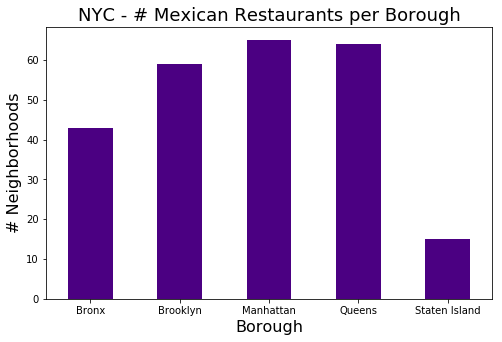

In [19]:
NYC_Mexican_Restaurants.groupby('Borough')['ID'].count().plot.bar(figsize=(8,5), color="indigo")
pyplot.title('NYC - # Mexican Restaurants per Borough', fontsize = 18)
pyplot.xlabel('Borough', fontsize = 16)
pyplot.xticks(rotation = 'horizontal')
pyplot.ylabel('# Neighborhoods',fontsize = 16)
pyplot.show()

#### So Manhattan is the borough with the largest number of Mexican restaurants.
#### Let's look at the neighborhoods with the highest count of Mexican restaurants.

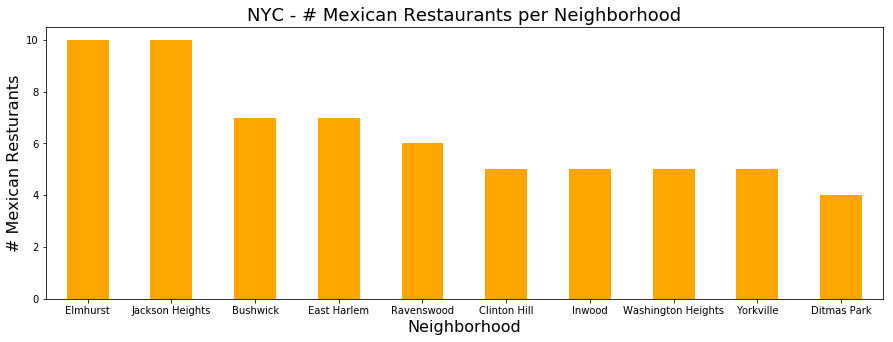

In [20]:
NYC_Mexican_Restaurants.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(15,5), color="orange")
pyplot.title('NYC - # Mexican Restaurants per Neighborhood', fontsize = 18)
pyplot.xlabel('Neighborhood', fontsize = 16)
pyplot.xticks(rotation = 'horizontal')
pyplot.ylabel('# Mexican Resturants', fontsize=16)
pyplot.show()

#### We have a tie...10 Mexican restaurants in the Elmhurst and Jackson Heights neighborhoods.  Both are in Queens!  Let's look at the details.

In [21]:
NYC_Mexican_Restaurants[NYC_Mexican_Restaurants['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
155,Queens,Elmhurst,4b91ca34f964a5209fd733e3,Tacos Mi Mexico Lindo
156,Queens,Elmhurst,5251b0b811d2e79764fd8bc7,Genesis Mexican Authentic Cuisine
157,Queens,Elmhurst,54c63464498e753931c565da,Juquila Mexican Cuisine
158,Queens,Elmhurst,53cc56bc498e5a7d7b0def8e,La Esquina Del Camaron Mexicano
159,Queens,Elmhurst,4d2b46ce467d6ea88f11df95,Tacos Al Suadero
160,Queens,Elmhurst,5bd229f1dff815002c9f4492,Tia Julia
161,Queens,Elmhurst,5a6e43be23a2e61c82a8396d,Sinaloeuse Comida Tipica Mexicana
162,Queens,Elmhurst,4eaa5b06b6347a596a023ab6,Taconazo Restaurante
163,Queens,Elmhurst,53e51708498e569365942fe2,SR Torteria Mexicana
164,Queens,Elmhurst,4ebf2e939a52cce4f34a122d,Maravillas Restaurant


In [22]:
NYC_Mexican_Restaurants[NYC_Mexican_Restaurants['Neighborhood']=='Jackson Heights']

,Borough,Neighborhood,ID,Name
145,Queens,Jackson Heights,4b91ca34f964a5209fd733e3,Tacos Mi Mexico Lindo
146,Queens,Jackson Heights,54c63464498e753931c565da,Juquila Mexican Cuisine
147,Queens,Jackson Heights,53cc56bc498e5a7d7b0def8e,La Esquina Del Camaron Mexicano
148,Queens,Jackson Heights,568ab53d498e748783593ebe,Chipotle Mexican Grill
149,Queens,Jackson Heights,4b80382bf964a520b15d30e3,El Coyote
150,Queens,Jackson Heights,4d2b46ce467d6ea88f11df95,Tacos Al Suadero
151,Queens,Jackson Heights,4ebf2e939a52cce4f34a122d,Maravillas Restaurant
152,Queens,Jackson Heights,5bd229f1dff815002c9f4492,Tia Julia
153,Queens,Jackson Heights,5a6e43be23a2e61c82a8396d,Sinaloeuse Comida Tipica Mexicana
154,Queens,Jackson Heights,4eaa5b06b6347a596a023ab6,Taconazo Restaurante


### Get the details regarding ratings and likes on the Mexican restaurants.
#### First, define a function to pull these details from the Foursquare API.

In [25]:
def GetVenueDetails(venue_id):
    # Set up url to call foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    #print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


### Call the Foursquare API and store the details data for each Mexican restaurant.

In [26]:
# Set up dataframe to hold details for Mexican restaurants
column_names=['Borough','Neighborhood','ID','Name','Likes','Rating','Tips']
ny_mex_rest_stats=pd.DataFrame(columns=column_names)

# Get the data from Foursquare API and append into the dataframe.
idx=1
for row in NYC_Mexican_Restaurants.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=GetVenueDetails(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id = ',ID)
        # Zero's for missing restaurants
        id, name, likes, rating, tips=[0]*5
    ny_mex_rest_stats = ny_mex_rest_stats.append({'Borough': Borough,
    'Neighborhood': Neighborhood, 'ID': id, 'Name' : name, 'Likes' : likes,
    'Rating' : rating, 'Tips' : tips}, ignore_index=True)
    idx+=1

                         ID                    Name  Likes  Rating  Tips
0  5c47a4b21953f3002c558218  Chipotle Mexican Grill      0     7.5     0
                         ID           Name  Likes  Rating  Tips
0  590e5d2ce96d0c61de2dcf1d  Cocina Chente     15     9.0     5
                         ID    Name  Likes  Rating  Tips
0  4db45c96fa8c350240e35919  Metate     19     7.0    10
                         ID                  Name  Likes  Rating  Tips
0  5217dd2811d2d06ccafb77d3  Estrellita Poblana V     24     7.9     8
                         ID                                Name  Likes  \
0  4ce81d330f196dcb5d2b43ae  Picante Picante Mexican Restaurant     19   

   Rating  Tips  
0     7.7    14  
                         ID           Name  Likes  Rating  Tips
0  590e5d2ce96d0c61de2dcf1d  Cocina Chente     15     9.0     5
                         ID                    Name  Likes  Rating  Tips
0  553d5376498e322eb4d37a1b  Chipotle Mexican Grill     31     7.7     1
           

#### Save details to a file, then re-reading and check to see if they're saved OK.

In [27]:
ny_mex_rest_stats.to_csv(path_or_buf=r'C:\Users\robertc.gray\Documents\Coursera Data Science\Course 9 Capstone\Week 4 and 5 Final Project\ny_Mexican_Restaurants_details2.csv',index=False)

In [28]:
NYC_mex_rest_stats = pd.read_csv(r'C:\Users\robertc.gray\Documents\Coursera Data Science\Course 9 Capstone\Week 4 and 5 Final Project\ny_Mexican_Restaurants_details2.csv')

In [30]:
NYC_mex_rest_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente,15,9.0,5
2,Bronx,Riverdale,4db45c96fa8c350240e35919,Metate,19,7.0,10
3,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V,24,7.9,8
4,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant,19,7.7,14


In [31]:
NYC_mex_rest_stats.describe()

,Likes,Rating,Tips
count,246.000000,246.000000,246.000000
mean,70.987805,6.866667,27.695122
std,200.765423,2.468584,73.157480
min,0.000000,0.000000,0.000000
25%,6.000000,6.900000,3.000000
50%,19.000000,7.600000,8.000000
75%,57.000000,8.200000,28.000000
max,1991.000000,9.100000,720.000000


### Check to see which neighborhoods have the highest ratings.

In [32]:
neighborhood_stats=NYC_mex_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(15)

,Neighborhood,Average Rating
42,Gramercy,8.800000
52,Hunters Point,8.800000
8,Belle Harbor,8.800000
31,East Village,8.750000
107,Stuyvesant Town,8.700000
111,Sutton Place,8.600000
86,Olinville,8.600000
100,Ridgewood,8.550000
104,Soho,8.500000
62,Little Italy,8.500000


### Check which boroughs have the highest ratings.

In [33]:
borough_stats=NYC_mex_rest_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_stats.columns=['Borough','Average Rating']
borough_stats.sort_values(['Average Rating'],ascending=False).head(5)

,Borough,Average Rating
2,Manhattan,7.924615
1,Brooklyn,7.508475
4,Staten Island,6.626667
0,Bronx,6.144186
3,Queens,5.742188


### Make plots of the average ratings by borough and top neighborhoods.

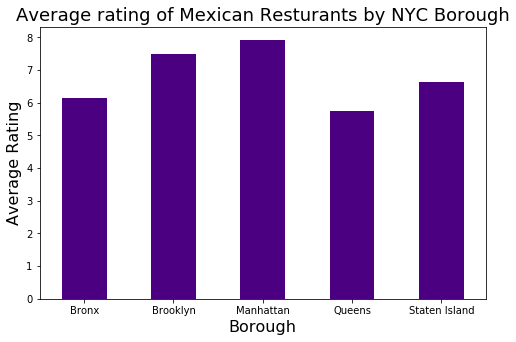

In [34]:
NYC_mex_rest_stats.groupby('Borough').mean()['Rating'].plot.bar(figsize=(8,5), color="indigo")
pyplot.title('Average rating of Mexican Resturants by NYC Borough', fontsize=18)
pyplot.xlabel('Borough', fontsize = 16)
pyplot.xticks(rotation = 'horizontal')
pyplot.ylabel('Average Rating', fontsize=16)
pyplot.show()

#### Showing the top 10 averages for the neighborhood ratings.

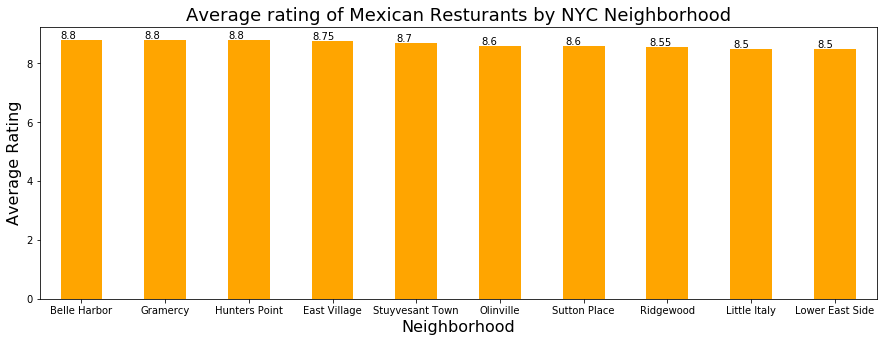

In [35]:
ax = NYC_mex_rest_stats.groupby('Neighborhood').mean()['Rating'].nlargest(10).plot.bar(figsize=(15,5), color="orange")
pyplot.title('Average rating of Mexican Resturants by NYC Neighborhood', fontsize=18)
pyplot.xlabel('Neighborhood', fontsize = 16)
pyplot.xticks(rotation = 'horizontal')
pyplot.ylabel('Average Rating', fontsize=16)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
pyplot.show()

### What individual restaurant has the highest ratings?

In [36]:
NYC_mex_rest_stats.iloc[NYC_mex_rest_stats['Rating'].idxmax()]

Borough                           Queens
Neighborhood                   Ridgewood
ID              51609091498eedc7cf34d817
Name                    Taquerias Kermes
Likes                                 50
Rating                               9.1
Tips                                  28
Name: 178, dtype: object

### And the one with the most likes?

In [37]:
NYC_mex_rest_stats.iloc[NYC_mex_rest_stats['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1991
Rating                               8.5
Tips                                 720
Name: 134, dtype: object

## AWARDS!!

### Borough:  We have Manhattan as the Borough with the highest average rating (7.92).

### Neighborhood:  We have Belle Harbor (in Queens), Grammercy (in Manhattan), and Hunter's Point (in Queens) tied as the Neighborhoods with the highest average rating (8.8).

### Restaurant:  We have Taquerias Kermes as the Restaurant with the highest rating (9.1).  Borough: Queens, Neighborhood: Ridgewood

### Restaurant:  We have La Esquina as the Restaurant with the most likes (1,991).  Borough: Manhattan, Neighborhood: Little Italy

### Now, to plot the best restaurants, those with scores of 8.0 or more...first set up data for the plot.

In [51]:
Plot_neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=8.0]
Plot_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
42,Gramercy,8.800000
8,Belle Harbor,8.800000
52,Hunters Point,8.800000
31,East Village,8.750000
107,Stuyvesant Town,8.700000
86,Olinville,8.600000
111,Sutton Place,8.600000
100,Ridgewood,8.550000
104,Soho,8.500000
75,Mott Haven,8.500000


### Merge in the lat, long, and Borough information.

In [50]:
Plot_neighborhood_stats1=pd.merge(Plot_neighborhood_stats, NYCneighborhoods, on='Neighborhood')
Plot_neighborhood_stats1=Plot_neighborhood_stats1[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
Plot_neighborhood_stats1.sort_values(['Average Rating'],ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
11,Manhattan,Gramercy,40.737210,-73.981376,8.800000
1,Queens,Belle Harbor,40.576156,-73.854018,8.800000
13,Queens,Hunters Point,40.743414,-73.953868,8.800000
6,Manhattan,East Village,40.727847,-73.982226,8.750000
32,Manhattan,Stuyvesant Town,40.731000,-73.974052,8.700000
24,Bronx,Olinville,40.871371,-73.863324,8.600000
34,Manhattan,Sutton Place,40.760280,-73.963556,8.600000
28,Queens,Ridgewood,40.708323,-73.901435,8.550000
30,Manhattan,Soho,40.722184,-74.000657,8.500000
17,Manhattan,Lower East Side,40.717807,-73.980890,8.500000


### Now, create a map for the top neighborhoods for great Mexican restaurants!!

In [40]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [44]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)
places = folium.map.FeatureGroup()
# add markers to map
for lat, lng, in Plot_neighborhood_stats1[['Latitude','Longitude']].values:
    places.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.6
        )
    )
map_newyork.save('index.html')

In [45]:
# Create pop-up label (Borough, Neighborhood, Average Rating)
Plot_neighborhood_stats1['Label']=Plot_neighborhood_stats1['Neighborhood']+', '+Plot_neighborhood_stats1['Borough']+'('+Plot_neighborhood_stats1['Average Rating'].map(str)+')'
# Add labels to map
for lat, lng, label in Plot_neighborhood_stats1[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(map_newyork)        
# add popup information to map
map_newyork.add_child(places)
map_newyork
# Can now click on a marker to see the Borough, Neighborhood, and Average Rating of Mexican restaurants in that neighborhood!!

Can now click on a marker to see the Borough, Neighborhood, and Average Rating of Mexican restaurants in that neighborhood!!

### Results

Manhattan is the Borough with the highest average rating (7.92).

Belle Harbor (in Queens), Grammercy (in Manhattan), and Hunter's Point (in Queens) are tied as the Neighborhoods with the highest average rating (8.8).

We have Taquerias Kermes as the Restaurant with the highest rating (9.1). Borough: Queens, Neighborhood: Ridgewood 

We have La Esquina as the Restaurant with the most likes (1,991). Borough: Manhattan, Neighborhood: Little Italy



### Discussion 

I would recommend Manhattan as the best boroughs for Mexican food in New York City.  Manhattan has the least number of neighborhoods, but the most Mexican restaurants.  Queens has the second most restaurants, and Queens has some of the top-rated restaurants, however Queens has an average rating of only 5.7, while Manhattan has an overall rating of 7.9.  Brooklyn has the third most Mexican restaurants, and has an average rating of 7.5, so I would recommend Brooklyn as the second best borough after Manhattan for Mexican restaurants.

If I were to open a new Mexican restaurant in New York City, I'd choose the neighborhood Gramercy in Manhattan.  It has the highest average rating for Mexican restaurants, so there's a demand there and people are used to going there for great Mexican food.  With that sort of draw, I believe people would give new Mexican restaurant a chance there!



### Conclusion

With the Data Science methodology and tools we've learned in this course, it was fairly straightforward to process a whole lot of data and to come up with these statistics and recommendations regarding Mexican restaurants in New York City.  I'm happy to have learned this material and am looking forward to useing it in the future for all sorts of things!